<font color='red'> <h1><center> Premiere TS (iloc 0, Liste2): Valeurs utiles : </h1> </font> || <h2> <center> U = 2.15 || h = 100 || Tension = 32100 </h2>

<font color='red'> <h1><center> Importation modules </h1> </font>

In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import yaml
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error
import sys
sys.path.append("..")
from uvsw_part import simulation
import copy
from math import e

<font color='red'> <h1> <center>Chargement fichier config | Verification variables </h1> </font>

In [3]:
data_list = pd.read_csv("../data/List2.txt" , delim_whitespace=True)
data_list.head(10)

,nc,md,U[m/s],d[m],m[kg/m],L[m],H[N],Nt,Dt[s],tf[s],ymax[m],filename
0,1,2,1.86,0.025,1.57,1,500,46556,0.0004,18.6224,0.000071,Data2.1.bin
1,2,2,1.88,0.025,1.57,1,500,100000,0.0004,40.0000,0.001031,Data2.2.bin
2,3,2,1.90,0.025,1.57,1,500,100000,0.0004,40.0000,0.001903,Data2.3.bin
3,4,2,1.92,0.025,1.57,1,500,100000,0.0004,40.0000,0.001796,Data2.4.bin
4,5,2,1.94,0.025,1.57,1,500,100000,0.0004,40.0000,0.000429,Data2.5.bin
5,6,2,1.98,0.025,1.57,1,500,23652,0.0004,9.4608,0.000088,Data2.6.bin
6,7,2,2.23,0.025,1.57,1,500,4767,0.0004,1.9068,0.000024,Data2.7.bin
7,8,2,3.80,0.025,1.57,1,2000,77718,0.0002,15.5436,0.000539,Data2.8.bin
8,9,2,3.82,0.025,1.57,1,2000,100000,0.0002,20.0000,0.001170,Data2.9.bin
9,10,2,3.83,0.025,1.57,1,2000,100000,0.0002,20.0000,0.001216,Data2.10.bin


In [4]:
def root_mean_squared_error(y_test,y_pred):
    """
    Calcule le root_mean_squared_error (RMSE)
    
    Paramètres
    ----------
    y_test
    y_pred
    
    Return
    ------
    
    RMSE
    

    """
    return np.sqrt(mean_squared_error(y_test,y_pred))

<h1> <center> Test d'une <u> unique série </u> temporelle avec des valeurs différentes de cl0  </center> </h1>

################ cl0 value: 0.6 ################
h value:  100.0  u value:  2.15  tension value:  32100.0
tf value  18.6224


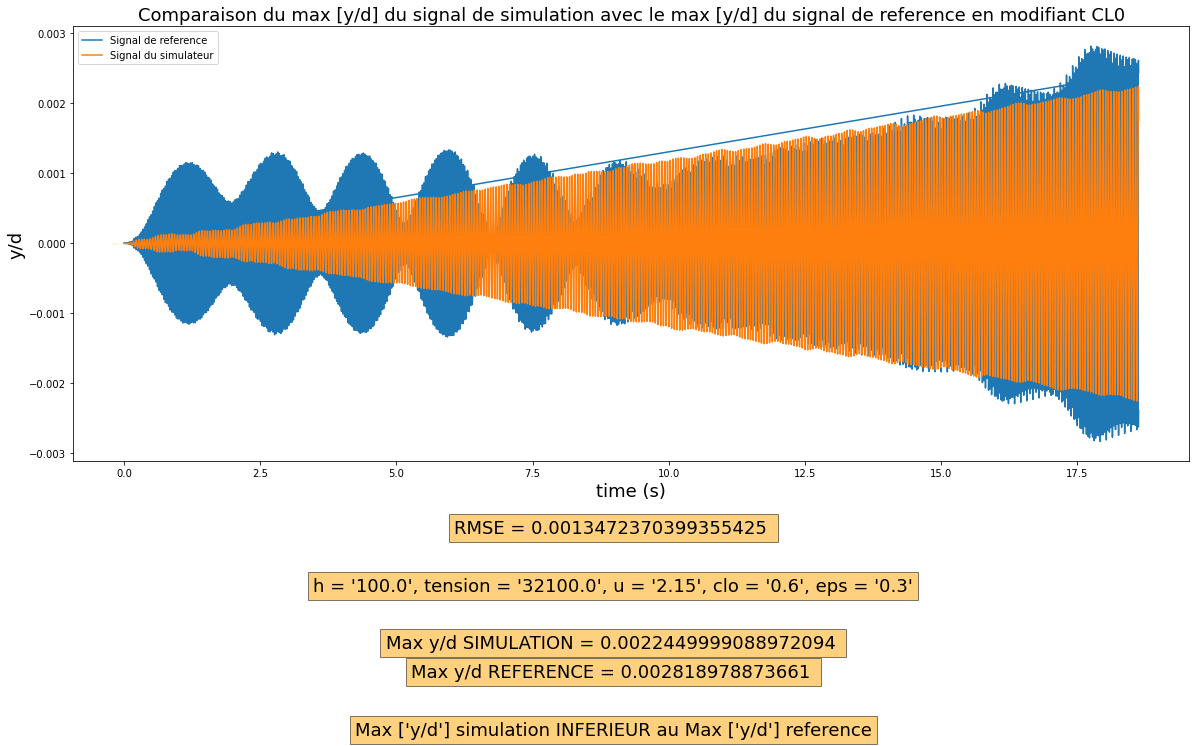

R2 :  -0.8301956526529186
MSE :  1.8150476417742827e-06


In [5]:

h = 100
tension = 32100
u = 2.15

clo_list = [0.6]

eps = 0.3

set_params = data_list.iloc[0,:]

ref = pd.read_csv("../data/csv/Liste2/graph{}.csv".format(set_params["nc"]))

for clo_value in clo_list: 

    print("################ cl0 value: {} ################".format(clo_value))
    cfg = yaml.safe_load(open('../data/config/example.in.yaml', 'r'))

    #cfg["cable"]["h"] = float(set_params["H[N]"])
    
    cfg["cable"]["h"] = float(h)

    cfg["simulation"]["tf"] = float(set_params["tf[s]"])

    cfg["cable"]["tension"] = float(tension)
    #cfg["cable"]["tension"] = float(T_value)

    #cfg["wakeosc"]["u"] = float(u_value)
    #cfg["wakeosc"]["u"] = float(set_params["U[m/s]"])
    cfg["wakeosc"]["u"] = u
    cfg["wakeosc"]["cl0"]= float(clo_value)
    cfg["wakeosc"]["eps"]= float(eps)

    cfg["simulation"]["dt"] = cfg["simulation"]["tf"] / len(ref) # MODIF DT
    cfg["simulation"]["dr"] = cfg["simulation"]["tf"] / len(ref) # MODIF DR



    print("h value: ", cfg["cable"]["h"], " u value: ", cfg["wakeosc"]["u"]," tension value: ",cfg["cable"]["tension"])
    print("tf value ", cfg["simulation"]["tf"])
    dfy, _ = simulation.run_cable_wakeosc(cfg)
    
    mse = mean_squared_error(ref['y/d'],(dfy['s=0.250']/0.025).values[:-1])
    rmse = root_mean_squared_error(ref['y/d'],(dfy['s=0.250']/0.025).values[:-1])
    mea = mean_absolute_error(ref['y/d'],(dfy['s=0.250']/0.025).values[:-1])
    
    max_ref = max(ref['y/d'])
    
    max_sim = max((dfy['s=0.250']/0.025).values[:-1])
    
    compare_text = ""
    
    if(max_sim < max_ref):
        compare_text = "Max ['y/d'] simulation INFERIEUR au Max ['y/d'] reference"
    if(max_sim > max_ref):
        compare_text = "Max ['y/d'] simulation SUPERIEUR au Max ['y/d'] reference"
    if(max_sim == max_ref):
        compare_text = "Max ['y/d'] simulation EGAL au Max ['y/d'] reference"
        
        
    

    mse_text= "MSE = %s " % mse
    rmse_text = "RMSE = %s " % rmse
    mea_text = "MEA = %s " % mea
    max_ref = "Max y/d REFERENCE = %s " % max_ref
    max_sim = "Max y/d SIMULATION = %s " % max_sim
    
    valeur_modifie_text = "Valeur modifiée = '{0}'".format(cfg["wakeosc"]["cl0"])

    #print(r2_score(ref['y/d'],simulation['y/d'][:-1]))
    #print(mean_squared_error(ref['y/d'],simulation['y/d'][:-1])) # Moi qui ai testé

    plt.figure(figsize = (20,8))
    plt.plot(ref['time'], ref['y/d'], label = "Signal de reference")
    plt.plot(dfy.index, dfy['s=0.250']/0.025, label = "Signal du simulateur")
    plt.xlabel('time (s)',fontsize=18)
    plt.ylabel('y/d',fontsize=18)

    #plt.figtext(0.5, 0.00, mse_text, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    plt.figtext(0.5, 0.00, rmse_text, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    #plt.figtext(0.5, -0.10, mea_text, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})


    plt.figtext(0.5, -0.10, "h = '{0}', tension = '{1}', u = '{2}', clo = '{3}', eps = '{4}'".format(cfg['cable']['h'],cfg['cable']['tension'],cfg['wakeosc']['u'],cfg["wakeosc"]["cl0"],cfg["wakeosc"]["eps"]), ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    
    plt.figtext(0.5, -0.20, max_sim, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    plt.figtext(0.5, -0.25, max_ref, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    
    plt.figtext(0.5, -0.35, compare_text, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})



    
    title = "Comparaison du max [y/d] du signal de simulation avec le max [y/d] du signal de reference en modifiant CL0"
    plt.title(title,fontsize=18)

    plt.legend()
    plt.show() 
    #print(r2_score(ref['y/d'],dfy['s=0.250']/0.025[:-1]))
    #print(mean_squared_error(ref['y/d'],dfy['s=0.250']/0.025[:-1])) # Moi qui ai testé

    print("R2 : ",r2_score(ref['y/d'],(dfy['s=0.250']/0.025).values[:-1]))
    print("MSE : ",mean_squared_error(ref['y/d'],(dfy['s=0.250']/0.025).values[:-1])) # Correct


